## This notebook contains examples and plots related to importance sampling for the pricing of options. It is a mix of examples from Glasserman's book "Monte Carlo Methods for Financial Engineering" and his paper "Importance and Stratified Sampling for Pricing Path-Dependent Options".

### First we just try pricing a deep out-of-the-money knock-in binary option. This first cell simulates MC paths with respect to the risk-neutral measaure.

In [1]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

repeats = 1*10**3

H = 85.
K = 105.
T = 1.
m = 50

r = 0.05
sigma = 0.15
S0 = 95.
potential_payoff = 10000.
h = T / float(m)
times = np.linspace(0, T, m+1)

normals = np.random.normal(loc=h*(r - 0.5 * sigma**2), scale=np.sqrt(h)*sigma, size=(repeats, m))
L = np.cumsum(normals, axis=1)
L = np.concatenate((np.zeros((repeats, 1)), L), axis=1)
S = S0 * np.exp(L)

vanilla_mc_option_payoff_active = np.any(S < H, axis=1) & (S[:,-1] > K)
vanilla_mc_payoffs = potential_payoff * np.exp(-r * T) * vanilla_mc_option_payoff_active
vanilla_mc_estimated_price = np.mean(vanilla_mc_payoffs)
vanilla_mc_std_err = np.std(vanilla_mc_payoffs) / np.sqrt(repeats)

vanilla_mc_df = pd.DataFrame(S.T)
vanilla_mc_df['times'] = times
vanilla_mc_df = pd.melt(vanilla_mc_df, id_vars='times')
vanilla_mc_df['variable'] = vanilla_mc_df['variable'].astype(np.int64)
vanilla_mc_df['option_payoff_active'] = vanilla_mc_option_payoff_active[vanilla_mc_df['variable'].values]

print('Done.')

Done.


### Now we price the same option, but use importance sampling (change of drift). Essentially, we add a negative drift to reach the knock-in level, and once we reach it, we add a positive drift to end up in-the-money.

In [2]:
b = -np.log(H / S0)
c = np.log(K / S0)
theta_minus = 0.5 - r / sigma**2 - (2*b+c) / float(T * sigma**2)
theta_plus = 0.5 - r / sigma**2 + (2*b+c) / float(T * sigma**2)
psi_theta_plus = (r - 0.5 * sigma**2) * h * theta_plus + 0.5 * sigma**2 * h * theta_plus**2

pos_new_mean = (2*b+c)/T
neg_new_mean = -(2*b+c)/T

normals = np.random.normal(loc=h*neg_new_mean, scale=np.sqrt(h)*sigma, size=(repeats, m))
L = np.cumsum(normals, axis=1)
L = np.concatenate((np.zeros((repeats, 1)), L), axis=1)
S_tilde = S0 * np.exp(L)
below_knockin = S_tilde < H

taus = np.zeros(repeats, dtype=np.int64)

for i in range(0, repeats):
    tau = np.argmax(below_knockin[i,:])
    
    start_of_new_normals = m
    
    if tau == 0:
        taus[i] = m
    else:
        start_of_new_normals = tau + 1
        taus[i] = tau
    
    if start_of_new_normals < m:
        number_required = m - start_of_new_normals
        normals[i,start_of_new_normals:] = np.random.normal(loc=h*pos_new_mean, scale=np.sqrt(h)*sigma, size=number_required)

L = np.cumsum(normals, axis=1)
L = np.concatenate((np.zeros((repeats, 1)), L), axis=1)
S = S0 * np.exp(L)

LR = np.zeros(repeats)

for i in range(0, repeats):
    L_tau = L[i,taus[i]]
    L_m = L[i,-1]
    LR[i] = np.exp((theta_plus - theta_minus) * L_tau - theta_plus * L_m + m * psi_theta_plus)

importance_mc_option_payoff_active = np.any(S < H, axis=1) & (S[:,-1] > K)
importance_mc_payoffs = potential_payoff * np.exp(-r * T) * np.multiply(LR, importance_mc_option_payoff_active)
importance_mc_estimated_price = np.mean(importance_mc_payoffs)
importance_mc_std_err = np.std(importance_mc_payoffs) / np.sqrt(repeats)

importance_mc_df = pd.DataFrame(S.T)
importance_mc_df['times'] = times
importance_mc_df = pd.melt(importance_mc_df, id_vars='times')
importance_mc_df['variable'] = importance_mc_df['variable'].astype(np.int64)
importance_mc_df['option_payoff_active'] = importance_mc_option_payoff_active[importance_mc_df['variable'].values]

print('Done.')

Done.


### Here are plots of the vanilla MC and IS paths (and also the pricing information) for the binary option. The first plot are the vanilla MC paths, and the second plot are the IS paths. The paths are orange if they ended up in-the-money, and they are blue otherwise.

*Vanilla MC*
Total number of paths: 1000
Number of paths with positive payoff: 18
Estimated price: 171.22129641012853 +- 39.99238202608544

-------------------------

*Importance sampling MC*
Total number of paths: 1000
Number of paths with positive payoff: 394
Estimated price: 123.88024954704306 +- 6.821877798114836

-------------------------

Variance improvement: 34.36739968295935


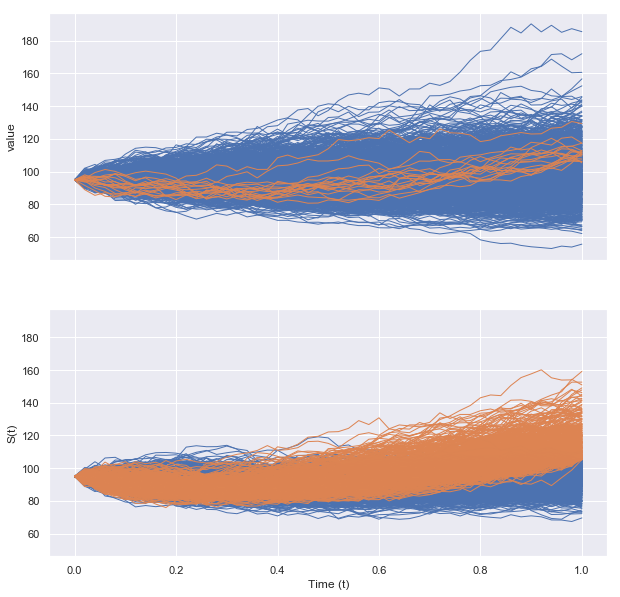

In [3]:
print('*Vanilla MC*')
print('Total number of paths: {}'.format(repeats))
print('Number of paths with positive payoff: {}'.format(np.sum(vanilla_mc_option_payoff_active)))
print('Estimated price: {} +- {}'.format(vanilla_mc_estimated_price, vanilla_mc_std_err))
print('\n-------------------------\n')

print('*Importance sampling MC*')
print('Total number of paths: {}'.format(repeats))
print('Number of paths with positive payoff: {}'.format(np.sum(importance_mc_option_payoff_active)))
print('Estimated price: {} +- {}'.format(importance_mc_estimated_price, importance_mc_std_err))
print('\n-------------------------\n')

print('Variance improvement: {}'.format((vanilla_mc_std_err / importance_mc_std_err)**2))

sns.set()

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
sns.lineplot(x='times', y='value', units='variable', hue='option_payoff_active', estimator=None, lw=1., data=vanilla_mc_df, legend=False, ax=axes[0])
sns.lineplot(x='times', y='value', units='variable', hue='option_payoff_active', estimator=None, lw=1., data=importance_mc_df, legend=False, ax=axes[1])
plt.ylabel('S(t)')
plt.xlabel('Time (t)')

fig.set_size_inches(10, 10)
plt.show()

### Next up is pricing a deep out-of-the-money asian call option. First we use vanilla MC.

In [4]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

repeats = 1*10**3

K = 55.
T = 1.
n = 16

r = 0.05
sigma = 0.1
S0 = 50.
dt = T / float(n)
times = np.linspace(0, T, n+1)

normals = np.random.normal(loc=0, scale=1, size=(repeats, n))
scaled_normals = (r-0.5*sigma**2)*dt + normals * sigma * np.sqrt(dt)
L = np.cumsum(scaled_normals, axis=1)
L = np.concatenate((np.zeros((repeats, 1)), L), axis=1)
S = S0 * np.exp(L)

vanilla_mc_payoffs = np.exp(-r * T) * np.maximum(np.mean(S[:,1:], axis=1) - K, 0)
vanilla_mc_estimated_price = np.mean(vanilla_mc_payoffs)
vanilla_mc_std_err = np.std(vanilla_mc_payoffs) / np.sqrt(repeats)

vanilla_mc_df = pd.DataFrame(S.T)
vanilla_mc_df['times'] = times
vanilla_mc_df = pd.melt(vanilla_mc_df, id_vars='times')
vanilla_mc_df['variable'] = vanilla_mc_df['variable'].astype(np.int64)

vanilla_mc_option_payoff_active = np.mean(S[:,1:], axis=1) > K
vanilla_mc_df['option_payoff_active'] = vanilla_mc_option_payoff_active[vanilla_mc_df['variable'].values]

print('Done.')

Done.


### Now we will price the same option, but we will compute an optimal change of drift. This is from the first example in Glassmerman's paper "Importance and stratified sampling for pricing path-dependent options."

#### First we need to compute the optimal change of drift by find the root of a nonlinear equation. We will find the root of my_func, and then use the root (y value) to get the drift vector (z value). Then once we have the optimal drift, we can run the simulations.

root: 1.9047064724206868


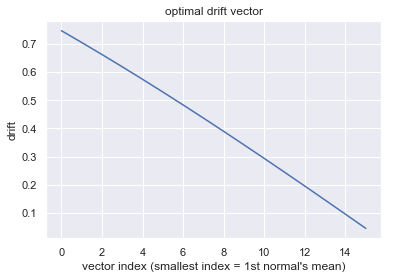

Done.


In [5]:
from scipy import optimize
import matplotlib.pyplot as plt

def my_func(y):
    z, S = get_z_and_S(y)
    return np.mean(S) - K - y

def get_z_and_S(y):
    S = np.zeros(n + 1)
    z = np.zeros(n)
    S[0] = S0
    z[0] = sigma * np.sqrt(dt) * (y + K) / y
    
    for i in range(1, n):
        S[i] = S[i-1] * np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z[i-1])
        z[i] = z[i-1] - sigma * np.sqrt(dt) * S[i] / (n * y)
    S[-1] = S[-2] * np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z[-1])
    
    return z, S

root = optimize.brentq(my_func, 0.01, 100)
print('root: {}'.format(root))
#we assume that the root is inside of D (i.e. this S path gives a positive payoff)
#I suspect that this is always the case, but it's something to keep in mind since it's not proved
optimal_drift, S = get_z_and_S(root)

#plot the optimal drift vector
plt.plot(optimal_drift)
plt.title('optimal drift vector')
plt.xlabel('vector index (smallest index = 1st normal\'s mean)')
plt.ylabel('drift')
plt.show()

#simulate the paths under the change of drift
normals = np.random.normal(loc=optimal_drift, scale=1, size=(repeats, n))
scaled_normals = (r-0.5*sigma**2)*dt + normals * sigma * np.sqrt(dt)
L = np.cumsum(scaled_normals, axis=1)
L = np.concatenate((np.zeros((repeats, 1)), L), axis=1)
S = S0 * np.exp(L)

LR = np.exp(-1 * normals.dot(optimal_drift) + 0.5 * optimal_drift.dot(optimal_drift))
importance_mc_payoffs = np.exp(-r * T) * np.multiply(np.maximum(np.mean(S[:,1:], axis=1) - K, 0), LR)
importance_mc_estimated_price = np.mean(importance_mc_payoffs)
importance_mc_std_err = np.std(importance_mc_payoffs) / np.sqrt(repeats)

importance_mc_df = pd.DataFrame(S.T)
importance_mc_df['times'] = times
importance_mc_df = pd.melt(importance_mc_df, id_vars='times')
importance_mc_df['variable'] = importance_mc_df['variable'].astype(np.int64)

importance_mc_option_payoff_active = np.mean(S[:,1:], axis=1) > K
importance_mc_df['option_payoff_active'] = importance_mc_option_payoff_active[importance_mc_df['variable'].values]

print('Done.')

### Here are plots of the vanilla MC and IS paths (and also the pricing information) for the asian call option. The first plot are the vanilla MC paths, and the second plot are the IS paths. The paths are orange if they ended up in-the-money, and they are blue otherwise.

*Vanilla MC*
Total number of paths: 1000
Number of paths with positive payoff: 124
Estimated price: 0.1995190175165276 +- 0.022459766242630002

-------------------------

*Importance sampling MC*
Total number of paths: 1000
Number of paths with positive payoff: 748
Estimated price: 0.19349321182550663 +- 0.004908841569063221

-------------------------

Variance improvement: 20.934010250623807


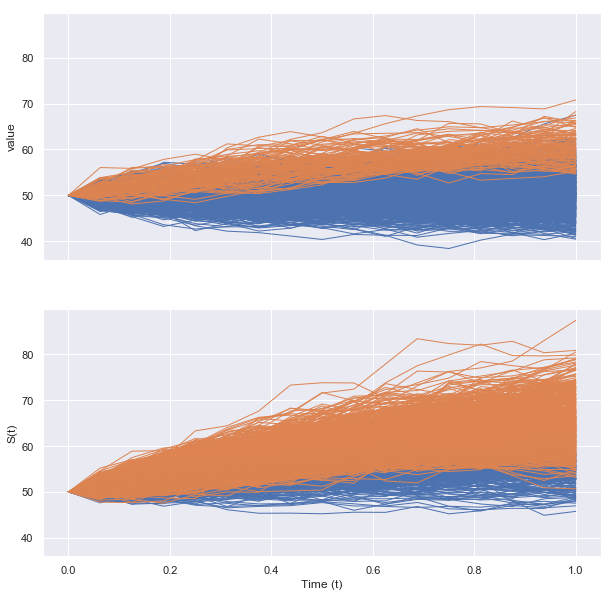

In [6]:
print('*Vanilla MC*')
print('Total number of paths: {}'.format(repeats))
print('Number of paths with positive payoff: {}'.format(np.sum(vanilla_mc_option_payoff_active)))
print('Estimated price: {} +- {}'.format(vanilla_mc_estimated_price, vanilla_mc_std_err))
print('\n-------------------------\n')
print('*Importance sampling MC*')
print('Total number of paths: {}'.format(repeats))
print('Number of paths with positive payoff: {}'.format(np.sum(importance_mc_option_payoff_active)))
print('Estimated price: {} +- {}'.format(importance_mc_estimated_price, importance_mc_std_err))
print('\n-------------------------\n')

print('Variance improvement: {}'.format((vanilla_mc_std_err / importance_mc_std_err)**2))

sns.set()

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
sns.lineplot(x='times', y='value', units='variable', hue='option_payoff_active', estimator=None, lw=1., data=vanilla_mc_df, legend=False, ax=axes[0])
sns.lineplot(x='times', y='value', units='variable', hue='option_payoff_active', estimator=None, lw=1., data=importance_mc_df, legend=False, ax=axes[1])
plt.ylabel('S(t)')
plt.xlabel('Time (t)')

fig.set_size_inches(10, 10)
plt.show()